# CIV1498 - Introduction to Data Science
## Project - Toronto Bike Share
## PART III: Modeling
### By: Gneiss Data (Greig Knox and Yoko Yanagimura)

In this section, we will work with the cleaned and merged bike station and weather data derived from Part I. We will explore the dataset to extract insights that will help develop a model to predict the  City of Toronto. 


## 0. Setup Notebook and Import Data

In [1]:
# Import 3rd party libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pytz
import chardet
import string
import datetime
import geopandas as gpd
import folium
import matplotlib.ticker as ticker
from folium import Choropleth
from folium import Marker
import holidays

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Centre all the charts displayed in this notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;
}
</style>
""")

We will import the cleaned bike trip dataset that will be used for analysis. 

In [2]:
#Import cleaned bike trip data
df_trips_data=pd.read_csv('df_merged_data.csv')
df_trips_data.set_index(keys='trip_id', drop=True, inplace=True)
df_trips_data.head()

,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,...,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
trip_id,,,,,,,,,,,,,,,,,,,,,
712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day


We will keep the backup of the trip data saved in a different variable, in case we need to reset the applied manipulations. 

In [3]:
#backup of the dataframe
df_trips_data2=df_trips_data.copy()

# 1. Understanding the Dataset

Before diving into the analysis, it is important to understand and define the following properties about our dataset. 
1. Structure - what is the format of our data file?

2.  Granularity - how fine or coarse is each row and column?

3. Scope - how complete is our data set?

Some of these questions were already explored in the Part I (Data Cleaning and Wrangling), but we would like to reiterate the subject in more details in this section. 

### Structure

The structure of the datafile can be examined by looking at the "shape". We can see that there are 7924851 rows and 32 columns. 

In [5]:
df_trips_data.shape

(8007423, 31)

What are the fields (e.g. columns) in each record? What is the type of each column? We can use .columns to examine this. We can see that there data about the trip and the associated information about the weather when the trip was taken. We joined the bike trip data and the weather dataframe together in Part I. 

In [6]:
df_trips_data.columns

Index(['subscription_id', 'trip_duration', 'start_station_id', 'start_time',
       'start_station_name', 'end_station_id', 'end_time', 'end_station_name',
       'bike_id', 'user_type', 'start_station_name_npl',
       'end_station_name_npl', 'start_station_lat', 'start_station_lon',
       'end_station_lat', 'end_station_lon', 'merge_time', 'year', 'month',
       'day', 'time', 'temp_c', 'dew_point_temp_c', 'rel_hum_',
       'wind_dir_10s_deg', 'wind_spd_kmh', 'visibility_km', 'stn_press_kpa',
       'hmdx', 'wind_chill', 'weather'],
      dtype='object')

To summarize the data cleaning conducted in Part I, the records removed from the dataset include:

- Trip records outside the January 1, 2017 and October 31, 2020 range 
- Trip records with extreme and unrealistic trip durations based on the inter-quartile range
- Trip records with unknown start or end locations (i.e. missing station name and station id)
- Trip records with start or end stations not included in the provided bike station dataset (i.e. unknown start and end coordinates)



In [7]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
subscription_id,3199754,40.0
trip_duration,0,0.0
start_station_id,0,0.0
start_time,0,0.0
start_station_name,0,0.0
end_station_id,0,0.0
end_time,0,0.0
end_station_name,0,0.0
bike_id,3199754,40.0
user_type,0,0.0


We use '.info' to see the datatype of each column contained the data_merged dataframe. 

We can see that the <code>'start_time',</code> and <code>'end_time'</code> need to be converted into datetime objects again localized to the EST timezone.

We can see that the <code>'start_station_id',</code> and <code>'end_station_id'</code> can be converted into integers. 



In [8]:
df_trips_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8007423 entries, 712441 to 10293875
Data columns (total 31 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   subscription_id         float64
 1   trip_duration           int64  
 2   start_station_id        float64
 3   start_time              object 
 4   start_station_name      object 
 5   end_station_id          float64
 6   end_time                object 
 7   end_station_name        object 
 8   bike_id                 float64
 9   user_type               object 
 10  start_station_name_npl  object 
 11  end_station_name_npl    object 
 12  start_station_lat       float64
 13  start_station_lon       float64
 14  end_station_lat         float64
 15  end_station_lon         float64
 16  merge_time              object 
 17  year                    int64  
 18  month                   int64  
 19  day                     int64  
 20  time                    object 
 21  temp_c                  f

In [9]:
#Convert start and end time into tz-aware datetime object
df_trips_data['start_time']=pd.to_datetime(df_trips_data['start_time'],utc=True)
df_trips_data['end_time']=pd.to_datetime(df_trips_data['end_time'],utc=True)
df_trips_data['merge_time']=pd.to_datetime(df_trips_data['merge_time'],utc=True)
df_trips_data['start_time']=df_trips_data['start_time'].dt.tz_convert(tz='US/Eastern')
df_trips_data['end_time']=df_trips_data['end_time'].dt.tz_convert(tz='US/Eastern')
df_trips_data['merge_time']=df_trips_data['merge_time'].dt.tz_convert(tz='US/Eastern')

print(df_trips_data['start_time'].dtype)
print(df_trips_data['end_time'].dtype)
print(df_trips_data['merge_time'].dtype)
df_trips_data.head()

datetime64[ns, US/Eastern]
datetime64[ns, US/Eastern]
datetime64[ns, US/Eastern]


,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,...,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
trip_id,,,,,,,,,,,,,,,,,,,,,
712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,annual member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day


In [10]:
#convert the station ids into integers
df_trips_data['end_station_id']=df_trips_data['end_station_id'].astype(int)
df_trips_data['start_station_id']=df_trips_data['start_station_id'].astype(int)

## Relationship between Temperature and Ride Count per hour

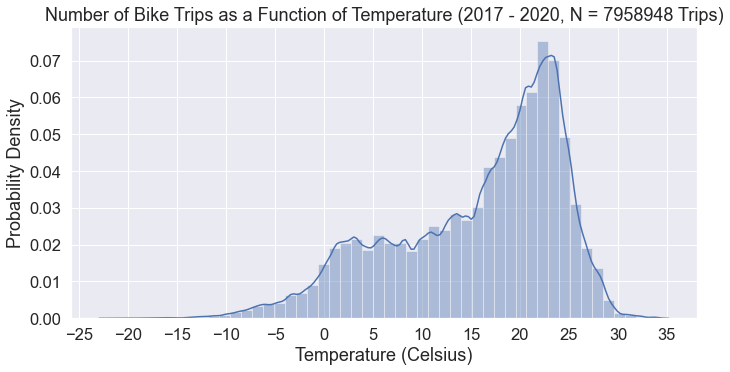

In [43]:
#Subset the data to only include trip records that contain temperature data
subset_temp=df_trips_data[df_trips_data['temp_c'].notnull()]
sns.set(font_scale=1.5)

fig1 = plt.figure(figsize=(10,5))
ax2 = fig1.subplots()

#map data
sns.distplot(subset_temp['temp_c'],ax = ax2, kde=True)
             
#formate titles
ax2.set_title("Number of Bike Trips as a Function of Temperature (2017 - 2020, N = 7958948 Trips)")
ax2.set_xlabel("Temperature (Celsius)" )
ax2.set_ylabel("Probability Density")
ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.show()

The below figure a violin plot showing the distribution of trip duration as a function of temperture. It shows that as the temperture increases, there is a larger proportion of longer trips.

The Effect of Relative Humidity on the Trip Duration. 

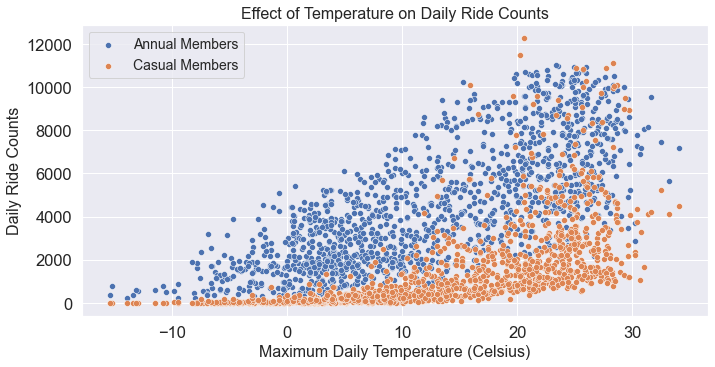

In [130]:
plt.figure(figsize=(10,5))

temp=sns.scatterplot(x=daily_rides_and_weathers['temp'],
                     y=daily_rides_and_weathers['annual_members'],
                     label="Annual Members")
sns.scatterplot(x=daily_rides_and_weathers['temp'],
                y=daily_rides_and_weathers['casual_members'],
                label="Casual Members")
temp.axes.set_title("Effect of Temperature on Daily Ride Counts",
                          fontsize=16)
temp.set_xlabel("Maximum Daily Temperature (Celsius)", fontsize=16)
#ride_scatter.set_ylim(0, 0.00035)
#ride_count.set_xlim(0, 14000)
temp.set_ylabel("Daily Ride Counts",
                      fontsize=16)
temp.legend(fontsize=14)
plt.show()

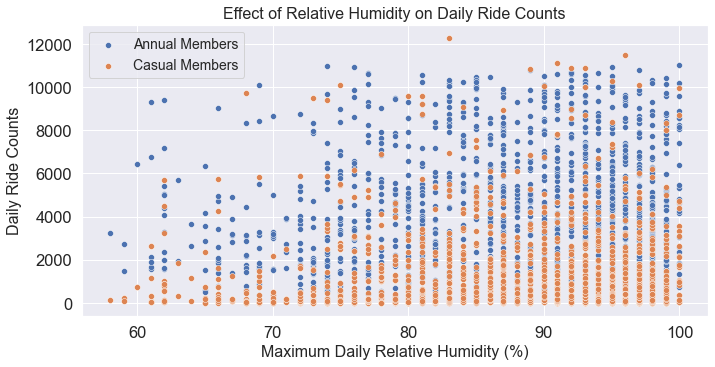

In [136]:
plt.figure(figsize=(10,5))

hum=sns.scatterplot(x=daily_rides_and_weathers['humidity'],
                     y=daily_rides_and_weathers['annual_members'],
                     label="Annual Members")
sns.scatterplot(x=daily_rides_and_weathers['humidity'],
                y=daily_rides_and_weathers['casual_members'],
                label="Casual Members")
hum.axes.set_title("Effect of Relative Humidity on Daily Ride Counts",
                          fontsize=16)
hum.set_xlabel("Maximum Daily Relative Humidity (%)", fontsize=16)
#ride_scatter.set_ylim(0, 0.00035)
#ride_count.set_xlim(0, 14000)
hum.set_ylabel("Daily Ride Counts",
                      fontsize=16)
hum.legend(fontsize=14)
plt.show()